In [19]:
import pickle
import plotly.graph_objects as go
import numpy as np
from utils import upscale_signal
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from evaluator import TSEvaluator
import seaborn as sns


#### Load labels

In [2]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})

main_periodicity = 4307.69 #value from main.ipynb
downsampling_rate = int(main_periodicity/40)
window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
labels = train_data['Normal/Attack'].values[::downsampling_rate]

### Shape anomaly detection Results

In [20]:
with open("outputs/shape_3_dict_opt_save_pso_NOPCA_STD.pkl", "rb") as f:
    data = pickle.load(f)
    N = len(data)
    shape_loss_original = data[0]["loss_ts"]
    shape_loss_optimized = data[N-1]["loss_ts"]
    shape_loss_original_upscaled = upscale_signal(shape_loss_original, labels.shape[0], stride, window_size, operator=np.maximum)
    shape_loss_optimized_upscaled = upscale_signal(shape_loss_optimized, labels.shape[0], stride, window_size, operator=np.maximum)

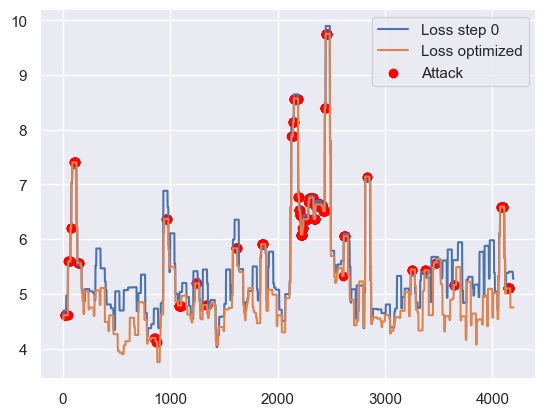

In [23]:

labels_abnormal_indices = np.where(labels == 1)[0]

sns.set()
plt.figure()
plt.plot(shape_loss_original_upscaled, label="Loss step 0")
plt.plot(shape_loss_optimized_upscaled, label="Loss optimized")
plt.scatter(labels_abnormal_indices, shape_loss_optimized_upscaled[labels_abnormal_indices], c = "red", label="Attack")
plt.legend()

### Check results

In [24]:
threshold_chosen = 5.5
labels_abnormal_indices = np.where(labels == 1)[0]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=labels_abnormal_indices, y=shape_loss_optimized_upscaled[labels_abnormal_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(shape_loss_optimized_upscaled)), y=shape_loss_optimized_upscaled, mode="lines", name="Loss optimized"))
fig.add_trace(go.Scatter(x=np.arange(len(shape_loss_optimized_upscaled)), y=[threshold_chosen for i in range(len(shape_loss_optimized_upscaled))], mode="lines", name="threshold chosen"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)




In [25]:
prediction = shape_loss_optimized_upscaled > threshold_chosen
evaluator = TSEvaluator(alpha_recall = 0)
recall_alpha0_chosen = evaluator.get_recall(labels, predicted_anomalies = prediction)
precision_chosen = evaluator.get_precision(labels, predicted_anomalies= prediction)
evaluator = TSEvaluator(alpha_recall = 1)
recall_overlap = evaluator.get_recall(labels, prediction)

print("Existence recall (percengtage of found anomalies): ", recall_alpha0_chosen)
print("Overlap recall (overlap with anomalies): ", recall_overlap)
print("Precision (overlap with prediction): ", precision_chosen)

Existence recall (percengtage of found anomalies):  0.5606060606060606
Overlap recall (overlap with anomalies):  0.5757575757575758
Precision (overlap with prediction):  0.19168563258636787


#### Calculate Precision and Recall depending on threshold


In [26]:
min_loss = min(min(shape_loss_optimized_upscaled), min(shape_loss_original_upscaled))
max_loss = max(max(shape_loss_optimized_upscaled), max(shape_loss_original_upscaled))
step = (max_loss - min_loss)/50
threshold= np.arange(min_loss, max_loss, step)
recall_alpha0_optim = []
recall_alpha1_optim = []
precision_optim = []


recall_alpha0_step0 = []
recall_alpha1_step0 = []
precision_step0 = []
for thres in threshold:
    #loss = upscale_signal(total_loss, labels.shape[0], stride, window_size, operator=np.maximum)
    predicted_labels_optim = shape_loss_optimized_upscaled > thres
    predicted_labels_step0 = shape_loss_original_upscaled > thres
    evaluator = TSEvaluator(alpha_recall = 0)
    recall_alpha0_step0.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_step0))
    recall_alpha0_optim.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_optim))
    precision_step0.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_step0))
    precision_optim.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_optim))
    evaluator = TSEvaluator(alpha_recall = 1)
    recall_alpha1_step0.append(evaluator.get_recall(labels, predicted_labels_step0 ))
    recall_alpha1_optim.append(evaluator.get_recall(labels, predicted_labels_optim ))

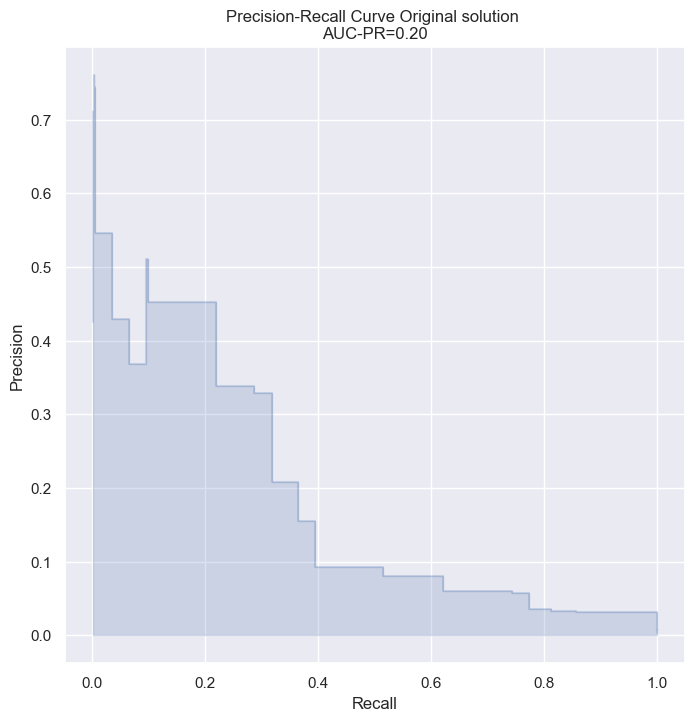

In [27]:
# Compute AUC-PR
auc_pr_original = auc(recall_alpha0_step0, precision_step0)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_step0, precision_step0, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_step0, precision_step0, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Original solution \nAUC-PR={auc_pr_original:.2f}')
plt.show()

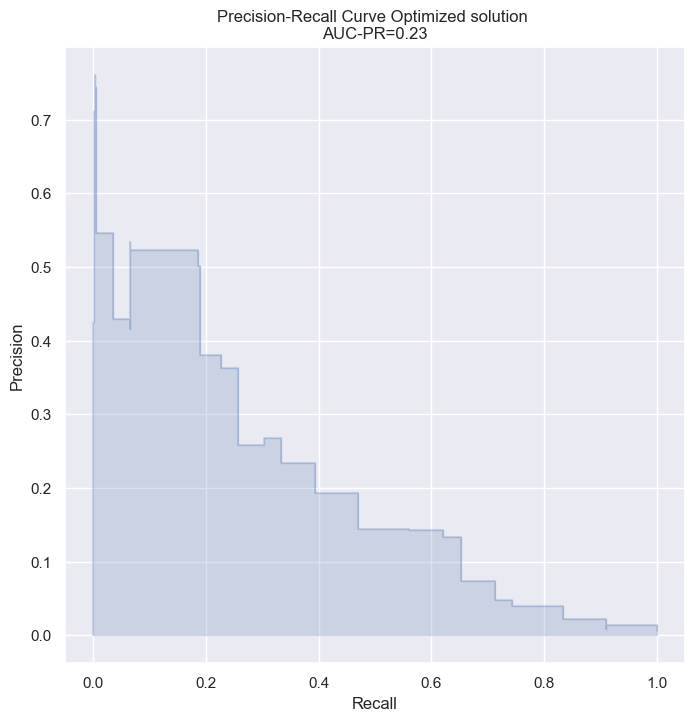

In [28]:
# Compute AUC-PR
auc_pr_optim = auc(recall_alpha0_optim, precision_optim)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_optim, precision_optim, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_optim, precision_optim, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Optimized solution \nAUC-PR={auc_pr_optim:.2f}')
plt.show()

## Amplitude Anomaly results

In [29]:
with open("outputs/3_dict_opt_save_pso_NOPCA_STD.pkl", "rb") as f:
    data = pickle.load(f)
    N = len(data)
    amplitude_loss_original = data[0]["loss_ts"]
    amplitude_loss_optimized = data[N-1]["loss_ts"]
    amplitude_loss_original_upscaled = upscale_signal(amplitude_loss_original, labels.shape[0], stride, window_size, operator=np.maximum)
    amplitude_loss_optimized_upscaled = upscale_signal(amplitude_loss_optimized, labels.shape[0], stride, window_size, operator=np.maximum)

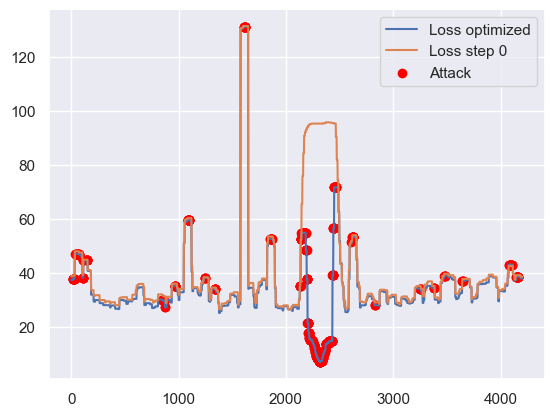

In [30]:
sns.set()
labels_abnormal_indices = np.where(labels == 1)[0]
figure = plt.figure()
plt.plot(amplitude_loss_optimized_upscaled, label="Loss optimized")
plt.plot(amplitude_loss_original_upscaled, label="Loss step 0")
plt.scatter(labels_abnormal_indices, amplitude_loss_optimized_upscaled[labels_abnormal_indices], c="red", label="Attack")
plt.legend()


In [31]:
threshold_chosen = 40
labels_abnormal_indices = np.where(labels == 1)[0]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=labels_abnormal_indices, y=amplitude_loss_original_upscaled[labels_abnormal_indices], mode="markers", name="Attack"
    )
)
fig.add_trace(go.Scatter(x=np.arange(len(amplitude_loss_original_upscaled)), y=amplitude_loss_original_upscaled, mode="lines", name="Loss optimized"))
fig.add_trace(go.Scatter(x=np.arange(len(amplitude_loss_original_upscaled)), y=[threshold_chosen for i in range(len(amplitude_loss_optimized_upscaled))], mode="lines", name="threshold chosen"))



fig.update_layout(
    xaxis_title="points index",
    yaxis_title="reconstruction loss"
)




In [32]:
prediction = amplitude_loss_optimized_upscaled > threshold_chosen
evaluator = TSEvaluator(alpha_recall = 0)
recall_alpha0_chosen = evaluator.get_recall(labels, predicted_anomalies = prediction)
precision_chosen = evaluator.get_precision(labels, predicted_anomalies= prediction)
evaluator = TSEvaluator(alpha_recall = 1)
recall_overlap = evaluator.get_recall(labels, prediction)

print("Existence recall (percengtage of found anomalies): ", recall_alpha0_chosen)
print("Overlap recall (overlap with anomalies): ", recall_overlap)
print("Precision (overlap with prediction): ", precision_chosen)

Existence recall (percengtage of found anomalies):  0.509555756570682
Overlap recall (overlap with anomalies):  0.5757575757575758
Precision (overlap with prediction):  0.21466049382716046


### Calculate precision and Recall

In [33]:
from evaluator import TSEvaluator
min_loss = min(min(amplitude_loss_optimized_upscaled), min(amplitude_loss_original_upscaled))
max_loss = max(max(amplitude_loss_optimized_upscaled), max(amplitude_loss_original_upscaled))
step = (max_loss - min_loss)/50
threshold= np.arange(min_loss, max_loss, step)
recall_alpha0_optim = []
recall_alpha1_optim = []
precision_optim = []


recall_alpha0_step0 = []
recall_alpha1_step0 = []
precision_step0 = []
for thres in threshold:
    #loss = upscale_signal(total_loss, labels.shape[0], stride, window_size, operator=np.maximum)
    predicted_labels_optim = amplitude_loss_optimized_upscaled > thres
    predicted_labels_step0 = amplitude_loss_original_upscaled > thres
    evaluator = TSEvaluator(alpha_recall = 0)
    recall_alpha0_step0.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_step0))
    recall_alpha0_optim.append(evaluator.get_recall(labels, predicted_anomalies = predicted_labels_optim))
    precision_step0.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_step0))
    precision_optim.append(evaluator.get_precision(labels, predicted_anomalies= predicted_labels_optim))
    evaluator = TSEvaluator(alpha_recall = 1)
    recall_alpha1_step0.append(evaluator.get_recall(labels, predicted_labels_step0 ))
    recall_alpha1_optim.append(evaluator.get_recall(labels, predicted_labels_optim ))

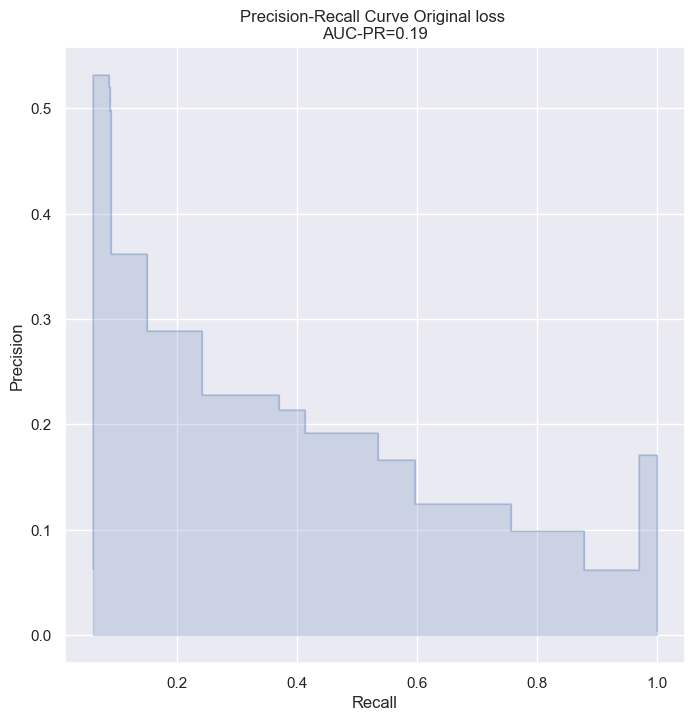

In [34]:
# Compute AUC-PR
auc_pr_original = auc(recall_alpha0_step0, precision_step0)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_step0, precision_step0, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_step0, precision_step0, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Original loss \nAUC-PR={auc_pr_original:.2f}')
plt.show()

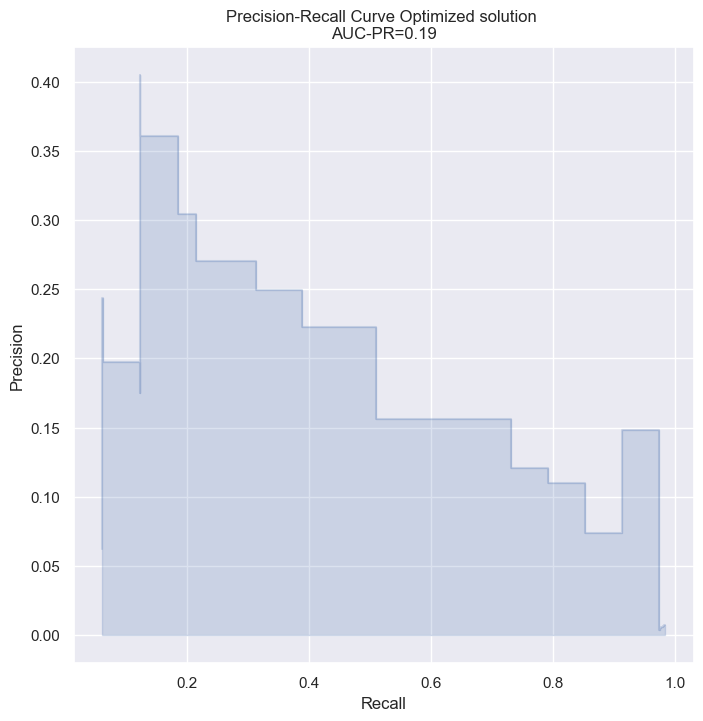

In [35]:
# Compute AUC-PR
auc_pr_optim = auc(recall_alpha0_optim, precision_optim)
# Plot the precision-recall curve
plt.figure(figsize=(8, 8))
plt.step(recall_alpha0_optim , precision_optim, color='b', alpha=0.2, where='post')
plt.fill_between(recall_alpha0_optim , precision_optim, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve Optimized solution \nAUC-PR={auc_pr_optim:.2f}')
plt.show()